In [14]:
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os


In [15]:
data_transfroms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(244),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),

    'val': transforms.Compose([
        transforms.RandomResizedCrop(244),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),

    'test': transforms.Compose([
        transforms.RandomResizedCrop(244),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [16]:
data_dir = "/Users/thekseniia/Projects/Programming/Rebelway/ml-course-week9/datasets/weather_recognition/main_data"

In [17]:
os.listdir(data_dir)

['.DS_Store', 'test', 'train', 'val']

In [18]:
print(f"Checking data directory: {data_dir}")


Checking data directory: /Users/thekseniia/Projects/Programming/Rebelway/ml-course-week9/datasets/weather_recognition/main_data


In [19]:
# Define dataset splits
sets = ['train', 'val', 'test']

# Load images from 'train', 'val', and 'test' folders inside 'data_dir'
# Apply transformations using `data_transforms` for each dataset
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transfroms[x]) for x in sets}

# Create DataLoaders to efficiently load images in batches
# - batch_size=32 → Each batch contains 32 images
# - shuffle=True → Randomly shuffles data (important for training)
# - num_workers=4 → Uses 4 worker threads to speed up data loading
dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4) for x in sets}

# Store dataset sizes (number of images in each split)
data_sizes = {x: len(image_datasets[x]) for x in sets}

# Get the list of class names (e.g., ['rain', 'snow', 'fog'])
class_names = image_datasets['train'].classes

In [20]:
# Check for MPS (Metal Performance Shaders) support
if torch.backends.mps.is_available():
    device = "mps"  # Use Metal backend for Apple Silicon
elif torch.cuda.is_available():
    device = "cuda"  # Use CUDA if available
else:
    device = "cpu"  # Fallback to CPU

device

'mps'

In [21]:
# Load EfficientNet B0 with pretrained weights
model_ft = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)

# Get the number of input features for the classifier layer
num_ftrs = model_ft.classifier[1].in_features  # EfficientNet uses classifier, not fc

# Replace the final classification layer
model_ft.classifier[1] = nn.Linear(num_ftrs, len(class_names))

In [22]:
# send to device
model_ft.to(device)




# loss function
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9) 
# optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001) for small models (takes longer)


In [23]:
import time
import copy

# store weight in variable to have acess to them
# create deep copy of the model

def train_model(model, criterion, optimizer, num_epochs =25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs-1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / data_sizes[phase]
            epoch_acc = running_corrects.float() / data_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc.item() > best_acc:
                best_acc = epoch_acc.item()  # Convert to Python float
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model


In [24]:
model_ft = train_model(model_ft, criterion, optimizer_ft, num_epochs=10)

Epoch 0/9
----------
train Loss: 1.6573 Acc: 0.5396
val Loss: 0.9767 Acc: 0.7889

Epoch 1/9
----------
train Loss: 0.8050 Acc: 0.7918
val Loss: 0.5589 Acc: 0.8622

Epoch 2/9
----------
train Loss: 0.5795 Acc: 0.8295
val Loss: 0.4465 Acc: 0.8754

Epoch 3/9
----------
train Loss: 0.4792 Acc: 0.8514
val Loss: 0.3954 Acc: 0.8783

Epoch 4/9
----------
train Loss: 0.4373 Acc: 0.8620
val Loss: 0.3630 Acc: 0.8974

Epoch 5/9
----------
train Loss: 0.4130 Acc: 0.8702
val Loss: 0.3322 Acc: 0.9076

Epoch 6/9
----------
train Loss: 0.3701 Acc: 0.8798
val Loss: 0.3303 Acc: 0.8856

Epoch 7/9
----------
train Loss: 0.3488 Acc: 0.8853
val Loss: 0.2952 Acc: 0.9047

Epoch 8/9
----------
train Loss: 0.3308 Acc: 0.8886
val Loss: 0.3122 Acc: 0.8915

Epoch 9/9
----------
train Loss: 0.3291 Acc: 0.8924
val Loss: 0.2760 Acc: 0.9194

Best val Acc: 0.919355


In [25]:
def evaluate_model(model):
    model.eval()
    running_corrects = 0

    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

        running_corrects += torch.sum(preds == labels.data)

    acc = running_corrects.float() / data_sizes['test']
    print(f'Test Accuracy: {acc:.4f}')

evaluate_model(model_ft)

Test Accuracy: 0.9152


In [26]:
# save model
torch.save(model_ft, 'weather_predict_model.pth')

In [27]:
# load model (if needed)
loaded_model = torch.load('weather_predict_model.pth')

/var/folders/x6/bmv8lbzx09dfp8plk95dtvvh0000gn/T/ipykernel_6377/2280545465.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load('weather_predict_mod

In [28]:
loaded_model.eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import PIL

In [30]:
def load_image(path):
    transform = transforms.Compose([
        transforms.Resize(256), #same as in the model
        transforms.CenterCrop(244),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    image = PIL.Image.open(path)
    image = transform(image).unsqueeze(0) # we need this for the plot
    return image


In [31]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0)) # hight, width, color
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

In [32]:
def predict_image(model, image):
    model.eval()
    image = image.to(device)
    with torch.no_grad():
        outputs = model(image)
        _, preds = torch.max(outputs, 1)
        return class_names[preds[0]],preds[0]

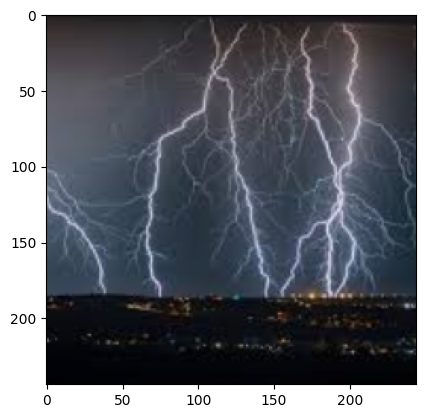

Predicted class: lightning (5)


In [37]:
image_path = '/Users/thekseniia/Projects/Programming/Rebelway/test-image.jpeg'

image = load_image(image_path)
plt.figure()
imshow(image.squeeze())
plt.show()

predicterd_class, predicterd_class_idx = predict_image(loaded_model, image)
print(f'Predicted class: {predicterd_class} ({predicterd_class_idx})')
